In [1]:
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# 注意這邊要跟你的資料夾位置一樣
path = "AZ_Handwritten_Data/"
class_filenames = os.listdir(path)
print('data number:',len(class_filenames))
N = len(class_filenames)
W = 28
H = 28

data number: 26000


In [3]:
images = np.empty((N, W, H, 1), dtype="uint8")
labels = np.array([0]* len(class_filenames))
print(images.shape)
print(labels.shape)

(26000, 28, 28, 1)
(26000,)


In [4]:
for i in range(N):
    labels[i] = ord(class_filenames[i][0])-65  # ord('A') = 65
    #print(class_filenames[i][0])
    #print(labels[i])
    img = cv2.imread(path+class_filenames[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = img.astype('float32')/255
    img = np.expand_dims(img, -1)
    #print(img.shape) (28, 28, 1)
    images[i,:,:,:] = img
    #break

(28, 28)


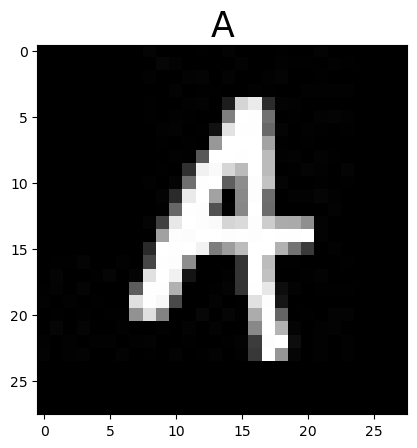

In [5]:
# 畫出第一張圖:
img = np.squeeze(images[0], -1)
#img = img.astype('float32')*255
print(img.shape)
plt.imshow(img, cmap="gray")
plt.title(chr(labels[0]+65), size=25)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
x_train_image, x_test_image, y_train_label, y_test_label = train_test_split(images, labels, test_size=0.2, random_state=42)
from collections import Counter
print("訓練集的類別數量：%s" %Counter(y_train_label))
print("訓練集的維度：", x_train_image.shape)
print("測試集的類別數量：%s" %Counter(y_test_label))
print("測試集的維度：", x_test_image.shape)

訓練集的類別數量：Counter({23: 824, 18: 818, 1: 818, 13: 813, 20: 810, 0: 809, 5: 809, 7: 808, 17: 807, 15: 806, 24: 805, 14: 805, 4: 805, 16: 803, 22: 802, 21: 800, 19: 797, 25: 797, 10: 791, 8: 788, 11: 787, 9: 786, 2: 782, 3: 781, 12: 779, 6: 770})
訓練集的維度： (20800, 28, 28, 1)
測試集的類別數量：Counter({6: 230, 12: 221, 3: 219, 2: 218, 9: 214, 11: 213, 8: 212, 10: 209, 19: 203, 25: 203, 21: 200, 22: 198, 16: 197, 4: 195, 24: 195, 14: 195, 15: 194, 17: 193, 7: 192, 5: 191, 0: 191, 20: 190, 13: 187, 18: 182, 1: 182, 23: 176})
測試集的維度： (5200, 28, 28, 1)


In [8]:
# 資料前處理 (正規化、維度改變、標籤讀熱編碼)
from tensorflow.keras.utils import to_categorical
import numpy as np
y_train = to_categorical(y_train_label)
y_test = to_categorical(y_test_label)
print("原始label:", y_train_label[5])
print("讀熱label:",y_train[5])

x_train = x_train_image.astype('float32')/255
x_test = x_test_image.astype('float32')/255
print("訓練集的維度：",x_train.shape)
print("測試集的維度：",x_test.shape)

原始label: 14
讀熱label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
訓練集的維度： (20800, 28, 28, 1)
測試集的維度： (5200, 28, 28, 1)


(28, 28)


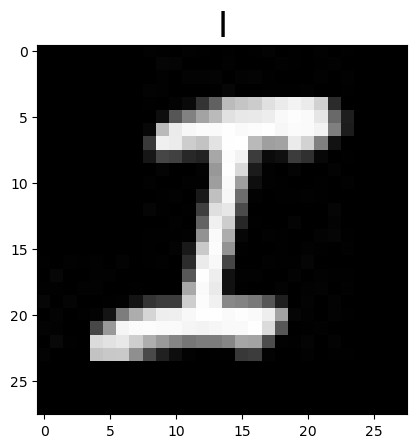

In [9]:
# 畫出訓練集:
img = np.squeeze(x_test[10], -1)
#img = img.astype('float32')*255
print(img.shape)
plt.imshow(img, cmap="gray")
plt.title(chr(y_test_label[10]+65), size=25)
plt.show()

In [10]:
# 建立模型
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

cnn = Sequential(name="English_handwriting")
cnn.add(Conv2D(16, (4,4), activation='relu', padding='same', input_shape=(28,28,1)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, (2,2), activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(26, activation='softmax'))

cnn.summary()
print("\n模型參數量:", cnn.count_params())

Model: "English_handwriting"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        272       
                                                                 
 dropout (Dropout)           (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 dense_1 (Dense)             (None, 26)        

In [11]:
# 設定優化器
from tensorflow.keras.optimizers import Adam
Adam = Adam(learning_rate=0.0001)

# 編譯方式
cnn.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['acc'])

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# 可視化訓練過程
tensorboard = TensorBoard(log_dir="my_log")

# 模型檢查點
model_checkpoint = ModelCheckpoint(filepath="weight.{epoch:02d}-{val_acc:.4f}.h5", 
                                monitor="val_acc", save_best_only=True, verbose=0)

In [12]:
# 訓練模型
history = cnn.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, shuffle=True, 
                               validation_data=(x_test, y_test), callbacks=[tensorboard, model_checkpoint])

Epoch 1/10
650/650 [==============================] - 6s 4ms/step - loss: 1.5100 - acc: 0.5958 - val_loss: 0.7725 - val_acc: 0.7769
Epoch 2/10
650/650 [==============================] - 3s 4ms/step - loss: 0.6985 - acc: 0.8030 - val_loss: 0.6083 - val_acc: 0.8310
Epoch 3/10
650/650 [==============================] - 3s 4ms/step - loss: 0.5693 - acc: 0.8424 - val_loss: 0.5095 - val_acc: 0.8587
Epoch 4/10
650/650 [==============================] - 3s 4ms/step - loss: 0.4775 - acc: 0.8690 - val_loss: 0.4484 - val_acc: 0.8781
Epoch 5/10
650/650 [==============================] - 3s 4ms/step - loss: 0.4059 - acc: 0.8892 - val_loss: 0.3971 - val_acc: 0.8912
Epoch 6/10
650/650 [==============================] - 2s 4ms/step - loss: 0.3506 - acc: 0.9038 - val_loss: 0.3472 - val_acc: 0.9065
Epoch 7/10
650/650 [==============================] - 2s 4ms/step - loss: 0.3074 - acc: 0.9162 - val_loss: 0.3150 - val_acc: 0.9144
Epoch 8/10
650/650 [==============================] - 2s 4ms/step - loss: 0.

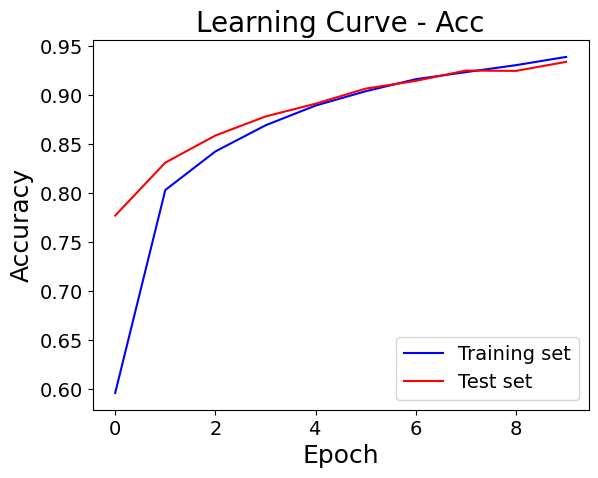

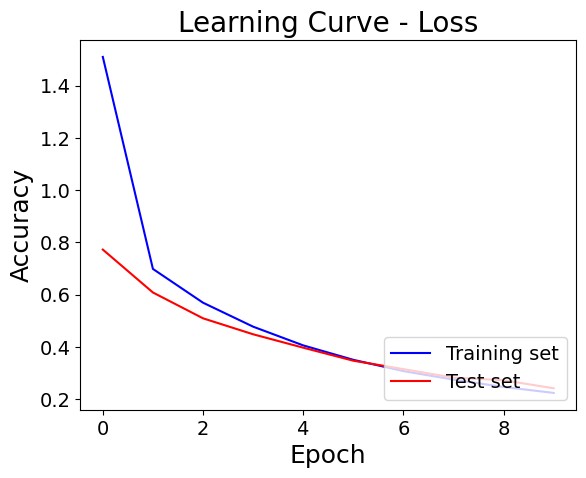

In [13]:
# 繪製訓練過程
acc = history.history['acc'];
loss = history.history['loss']
val_acc = history.history['val_acc'];
val_loss = history.history['val_loss']
plt.title("Learning Curve - Acc", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.plot(np.arange(len(acc)), acc,color='b', label="Training set")
plt.plot(np.arange(len(val_acc)), val_acc,color='r', label="Test set")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.show()

plt.title("Learning Curve - Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.plot(np.arange(len(loss)), loss,color='b', label="Training set")
plt.plot(np.arange(len(val_loss)), val_loss,color='r', label="Test set")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.show()

In [14]:
%load_ext tensorboard
%tensorboard --logdir=my_log

5200
5200
[[172   0   0   0   0   0   0   4   0   0   4   0   5   0   0   2   0   1
    0   0   0   0   0   2   1   0]
 [  0 162   0   3   3   0   1   0   0   0   1   0   0   0   1   4   0   2
    2   0   0   0   0   1   0   2]
 [  0   0 207   1   3   0   3   0   0   0   0   4   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]
 [  2   0   0 205   0   0   0   0   0   1   1   0   0   0   4   3   0   0
    2   0   0   0   0   0   0   1]
 [  0   0   2   1 174   0   5   0   0   0   3   4   0   0   0   0   1   1
    1   0   0   0   1   0   0   2]
 [  0   0   0   0   2 184   0   0   0   1   2   0   0   0   0   1   0   0
    0   1   0   0   0   0   0   0]
 [  0   1   2   0   3   0 213   0   0   1   0   7   0   0   0   0   1   0
    1   0   0   0   1   0   0   0]
 [  4   0   0   0   0   0   0 181   0   0   0   0   1   2   0   0   0   0
    0   0   1   0   1   1   0   1]
 [  0   0   0   1   0   0   0   0 207   1   0   0   0   0   0   0   0   0
    2   0   0   0   0   0   0   1]
 [  0   0

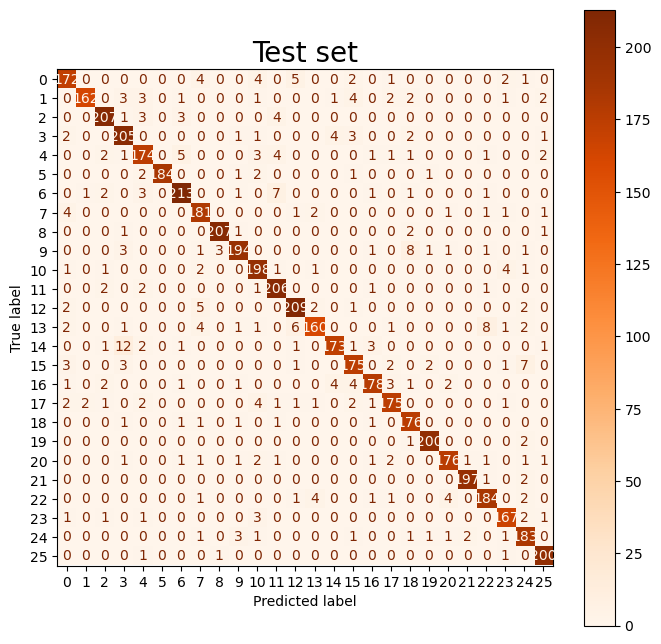

In [15]:
# 測試集預測
test_predict = cnn.predict(x_test)
test_predictions = [np.argmax(i) for i in test_predict]
print(len(y_test_label))
print(len(test_predictions))
# 混淆矩陣
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_cm = confusion_matrix(y_test_label, test_predictions)
print(test_cm)

disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot( cmap='Oranges')
fig = disp.figure_
fig.set_size_inches(8, 8)
plt.title('Test set', size = 20)
plt.show()

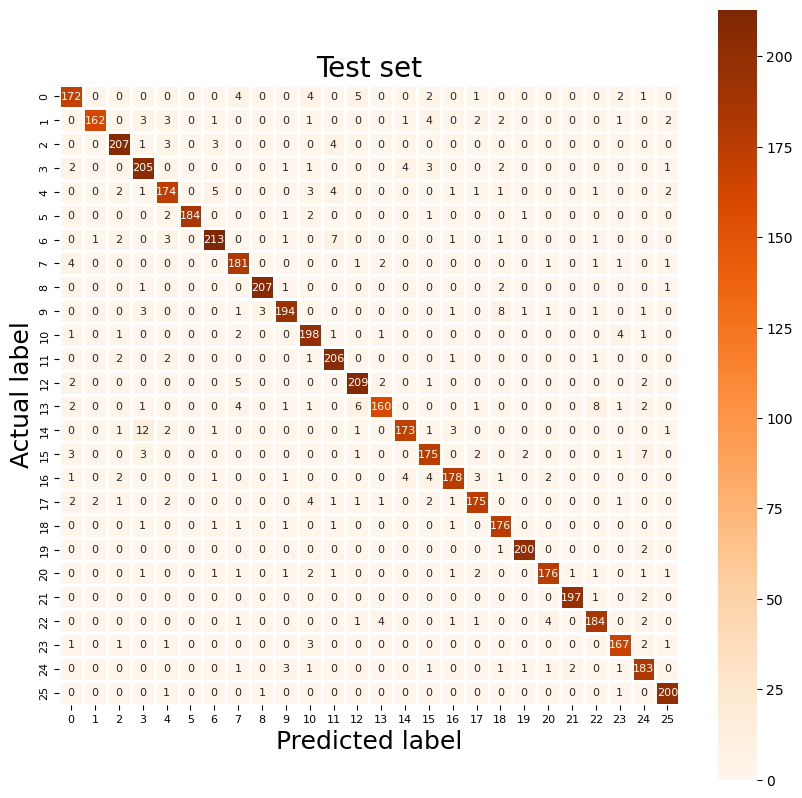

In [19]:
import seaborn as sns

plt.figure(figsize=(10,10))
plt.title('Test set', size = 20)
sns.heatmap(test_cm, annot=True, fmt=".0f", linewidths=1.0, 
                         square = True, cmap = "Oranges", annot_kws={"size":8})
plt.xlabel('Predicted label', size = 18)
plt.ylabel('Actual label', size = 18)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [20]:
train_loss, train_acc = cnn.evaluate(x_train, y_train)
print("訓練集的準確度:%0.4f" %(train_acc))
print("訓練集的損失值:%0.4f" %(train_loss))

test_loss, test_acc = cnn.evaluate(x_test, y_test)
print("測試集的準確度:%0.4f" %(test_acc))
print("測試集的損失值:%0.4f" %(test_loss))

650/650 [==============================] - 2s 3ms/step - loss: 0.1714 - acc: 0.9566
訓練集的準確度:0.9566
訓練集的損失值:0.1714
163/163 [==============================] - 0s 2ms/step - loss: 0.2416 - acc: 0.9338
測試集的準確度:0.9338
測試集的損失值:0.2416


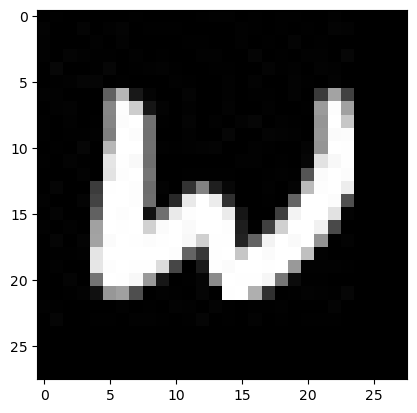

Ans:  W


In [29]:
from tensorflow.keras.models import load_model
cnn = load_model('weight.10-0.9360.h5')
import cv2
img = cv2.imread("W955.jpg")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap="gray")
plt.show()
resize_img = np.resize(gray_img, (28, 28))
test_image = resize_img.astype('float32')/255
test_image = np.expand_dims(test_image,-1)
test_image = np.expand_dims(test_image,0)
predict = cnn.predict(test_image)
#print(predict)
predictions = [np.argmax(one_hot)for one_hot in predict]
print("Ans: ",chr(predictions[0]+65))